# A Data-Driven Approach to Quarterback Drafting in Best Ball Mania

## Participant: Matthew Cooper

Twitter: https://twitter.com/coopfb <br>
Linkedin: https://www.linkedin.com/in/matthewcooper1624/ <br>
YouTube: https://www.youtube.com/@coop16

## Introduction 

As a lifelong fantasy football player, I grew up always being told to wait on drafting a quarterback because "they're all the same." For years, I, like many others in the fantasy football community, followed this advice. Fantasy football players have recently begun to stray from this method, however. Given this, I created my project to see what the **data** says about the **most optimal quarterback drafting strategy for making the playoffs** in Best Ball Mania. Should we be listening to the age-old advice of drafting late quarterbacks? Or should we be locking up a top quarterback early?

## Utilities

**Package Versions Used:** <br>
python 3.9 <br>
pandas==2.0.3 <br>
nfl_data_py <br>
numpy==1.24.0 <br>
matplotlib==3.7.2 <br>
scikit-learn==1.3.0 <br>
xgboost==1.7.6 <br>
shap==0.42.0 <br>

In [44]:
import os
import sklearn
import pandas as pd
import nfl_data_py as nfl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
from xgboost import XGBClassifier
from sklearn.inspection import PartialDependenceDisplay
import shap

In [27]:
name = "Matthew Cooper | @ CoopFB"

## Data Preparation

This section includes code for importing  all of the BBMIII (2022) data into a Python dataframe. I used both fast and mixed draft formats. Additionally, the BBMIII postseason data is loaded.

In [28]:
# Importing 2022 fast and mixed regular season data

reg_22_fast_directory = './data/2022/regular_season/fast/'
reg_22_mixed_directory = './data/2022/regular_season/mixed/'

reg_22_dfs = []
for filename in os.listdir(reg_22_fast_directory):
    if filename.endswith('csv'):
        filepath = os.path.join(reg_22_fast_directory, filename)
        df = pd.read_csv(filepath)
        reg_22_dfs.append(df)

for filename in os.listdir(reg_22_mixed_directory):
    if filename.endswith('csv'):
        filepath = os.path.join(reg_22_mixed_directory, filename)
        df = pd.read_csv(filepath)
        reg_22_dfs.append(df)

# Combining all 2022 draft data
reg_22 = pd.concat(reg_22_dfs, ignore_index=True)
reg_22.head()

draft_id                  draft_time  clock  \
0  d4e1b2c6-26e0-48ec-a2e9-ca4d43f00ade  2022-08-27 05:38:33.558728     30   
1  d4e1b2c6-26e0-48ec-a2e9-ca4d43f00ade  2022-08-27 05:38:33.558728     30   
2  d4e1b2c6-26e0-48ec-a2e9-ca4d43f00ade  2022-08-27 05:38:33.558728     30   
3  d4e1b2c6-26e0-48ec-a2e9-ca4d43f00ade  2022-08-27 05:38:33.558728     30   
4  d4e1b2c6-26e0-48ec-a2e9-ca4d43f00ade  2022-08-27 05:38:33.558728     30   

                         draft_entry_id                   tournament_entry_id  \
0  7336d518-d05e-4f45-9229-f61e24c0b6d3  6408bcff-e8a1-4d9b-a001-2a75106c613a   
1  61ca1fda-226c-4719-9b03-955e8c9b8fe5  a26bdf98-1180-499a-8a5f-83bc51411fd6   
2  6c505321-ae39-466a-ace2-1445ed993a45  0e92232b-a16b-42fd-a18a-e9d956b68654   
3  7336d518-d05e-4f45-9229-f61e24c0b6d3  6408bcff-e8a1-4d9b-a001-2a75106c613a   
4  d8518c24-eba6-49ff-925c-34efe5d90dc1  b65930ef-39d3-463b-84e1-fa5b6d05e40c   

        tournament_round_draft_entry_id  tournament_round_number  \
0  ec3b5930-e7f4-47e8-ad17-3bb430a16525                        1   
1  b41eec81-6482-4dfa-9000-e68f7a579cd3                        1   
2  1a91ea08-f183-4338-ae82-4f94290af4a4                        1   
3  ec3b5930-e7f4-47e8-ad17-3bb430a16525                        1   
4  17b3175f-7f9f-4bc0-96f6-077ab4b8301f                        1   

        player_name position_name  bye_week  projection_adp  pick_order  \
0  Courtland Sutton            WR         9           33.27          10   
1     Brevin Jordan            TE         6          194.50           5   
2       K.J. Osborn            WR         7          145.59           7   
3    James Robinson            RB        10          137.40          10   
4   Jamaal Williams            RB         6          156.86           8   

   overall_pick_number  team_pick_number  pick_points  roster_points  \
0                   34                 3         77.0        1491.90   
1                  188                16          9.5        1493.08   
2                  151                13         44.9        1467.62   
3                  130                11         65.6        1491.90   
4                  161                14        147.5        1680.26   

   playoff_team  
0             0  
1             0  
2             0  
3             0  
4             0

In [29]:
# Importing 2022 postseason data
post_22_directory = './data/2022/post_season/quarterfinals/'
post_22_dfs = []

for filename in os.listdir(post_22_directory):
    if filename.endswith('csv'):
        filepath = os.path.join(post_22_directory, filename)
        df = pd.read_csv(filepath)
        post_22_dfs.append(df)

post_22 = pd.concat(post_22_dfs, ignore_index=True)
post_22.head()

draft_id  draft_time  clock  \
0  00066e88-9401-4a03-a3bb-9ebd772e51d1         NaN     30   
1  00066e88-9401-4a03-a3bb-9ebd772e51d1         NaN     30   
2  00066e88-9401-4a03-a3bb-9ebd772e51d1         NaN     30   
3  00066e88-9401-4a03-a3bb-9ebd772e51d1         NaN     30   
4  00066e88-9401-4a03-a3bb-9ebd772e51d1         NaN     30   

                         draft_entry_id                   tournament_entry_id  \
0  8928124e-f386-4760-925b-b4cb6965aeeb  4ecbcfef-bcd2-4d58-922e-83f049897ffe   
1  228adebd-cd52-4659-a184-91e344c830a5  4a3d4c25-9d62-407c-8e5b-fe342bf98e5d   
2  82afda48-91e2-4fa6-aeee-4b2fd15175d0  a2bae341-3cd4-476e-99d8-222c811ec269   
3  84857aa4-d2ca-4fc5-921e-21f28b4b3baf  58ebcca2-bedb-403e-a70d-8b138fa9232d   
4  e6e813ae-17ad-4f5c-9829-2a06e0ea7283  4061a521-75e0-4094-9c8e-df6e58b46cfd   

        tournament_round_draft_entry_id  tournament_round_number  \
0  393b32a0-f016-4d80-9174-470f74b65202                        2   
1  9e896b68-9bd9-400b-87fd-8eba9b454d22                        2   
2  df83f6b7-4fde-469f-809b-b32ded66e91d                        2   
3  705d7131-5301-47b4-9cab-2045bf83d59c                        2   
4  d5900340-915d-453b-a682-5e255f3f2adf                        2   

       player_name position_name  bye_week  projection_adp  pick_order  \
0   Michael Gallup            WR         9             0.0           0   
1    Van Jefferson            WR         7             0.0           0   
2      Marlon Mack            RB         9             0.0           0   
3        Cole Kmet            TE        14             0.0           0   
4  Trevor Lawrence            QB        11             0.0           0   

   overall_pick_number  team_pick_number  pick_points  roster_points  \
0                   11                11         0.00         123.14   
1                  140                14         0.00          99.44   
2                  159                15        14.30         150.10   
3                  100                10         4.50         107.30   
4                  121                13        27.82         140.32   

   playoff_team  
0             1  
1             1  
2             1  
3             1  
4             1

In [30]:
# Making a QB only dataframe
qbs_22 = reg_22[reg_22['position_name'] == 'QB']

# Creating a set including the tournament_entry_ids of all playoff teams
postseason_teams = set(post_22['tournament_entry_id'])

# A lambda function to add a binary indicator column for postseason status
is_postseason = lambda entry_id: 1 if entry_id in postseason_teams else 0

In the above code block are some further steps in data preparation for the rest of the project.

In [31]:
rosters = nfl.import_rosters([2022])
pbp_22 = nfl.import_pbp_data([2022], downcast=True)

2022 done.
Downcasting floats.


Lastly, I loaded in both roster and play-by-play data for the 2022 season to supplement the BBMIII data. Both are included in the **nfl_data_py** package.

## The 'How': Quarterback Roster Composition

To begin, I looked at the most basic piece of information when it comes to quarterback drafting strategy: **how many** quarterbacks should you draft. To investigate this, I observed the roster composition of both playoff and non-playoff teams.

In [7]:
# Counting number of entries for each team in quarterback df, i.e. number of quarterbacks drafted
qb_counts = qbs_22.groupby('tournament_entry_id').size().reset_index(name='num_drafted')

# Add information about playoff status
qb_counts['made_playoffs'] = 0
qb_counts['made_playoffs'] = qb_counts['tournament_entry_id'].apply(is_postseason)

# Grouping the data together by playoff status and finding the proportion of each number of quarterbacks drafted
grouped_counts = qb_counts.groupby(['made_playoffs', 'num_drafted']).size().unstack()
count_proportions = grouped_counts.div(grouped_counts.sum(axis=1), axis=0)

I manipulated the quarterback data in order to find the proportion of playoff and non-playoff teams who drafted different numbers of quarterbacks.

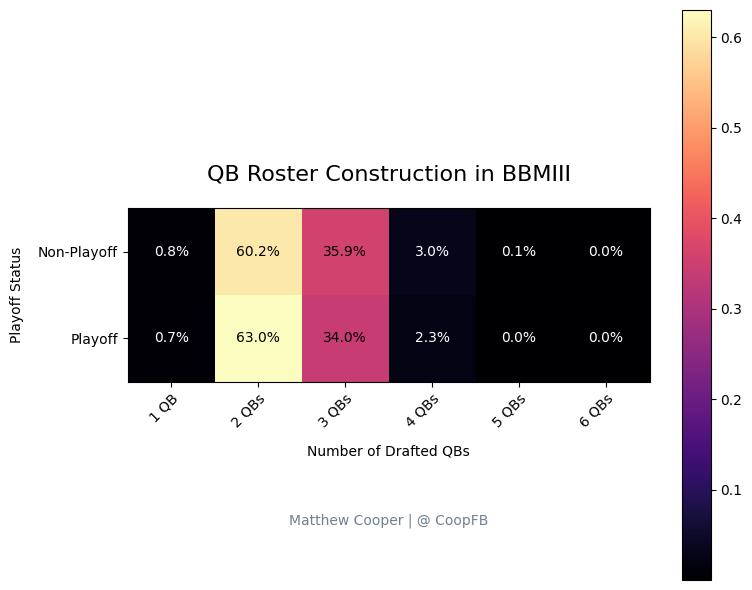

In [8]:
# Plotting the results
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(count_proportions.values, cmap='magma')

# Add the colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels
num_drafted_labels = ['1 QB', '2 QBs', '3 QBs', '4 QBs', '5 QBs', '6 QBs']
playoff_labels = ['Non-Playoff', 'Playoff']
ax.set_xticks(np.arange(len(num_drafted_labels)))
ax.set_yticks(np.arange(len(playoff_labels)))
ax.set_xticklabels(num_drafted_labels)
ax.set_yticklabels(playoff_labels)

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data and add text annotations for each percentage
for i in range(len(playoff_labels)):
    for j in range(len(num_drafted_labels)):
        bg_color = im.cmap(im.norm(count_proportions.values[i, j]))
        text_color = 'white' if np.mean(to_rgb(bg_color)) < 0.4 else 'black'
        text = ax.text(
            j,
            i,
            f"{count_proportions.values[i, j]*100:.1f}%",
            ha="center",
            va="center",
            color=text_color
        )

# Set plot title and labels
ax.set_title("QB Roster Construction in BBMIII", pad=20, fontsize=16)
ax.set_xlabel("Number of Drafted QBs", labelpad=10)
ax.set_ylabel("Playoff Status", labelpad=10)
plt.text(0.5, -0.8, name, ha="center", va="center", transform=ax.transAxes, color="slategray")


# Show the plot
plt.tight_layout()
# plt.savefig('qbs_rostered_22.png', dpi=300, facecolor='white')
plt.show()

As can be seen above, both playoff and non-playoff teams favored **2** quarterback builds with 63% and 60.2% of teams employing this strategy respectively. Another ~third of both playoff and non-playoff teams opted for a **3** quarterback build. Non-playoff teams explored more exotic quarterback builds (1 or 4+) at a slightly higher rate, however their lack of prevalence in the datatset does not warrant further investigation. <br>

The main takeaway here is that, in most cases, a **two quarterback build** is optimal. Though, in certain cases if drafting a third quarterback is warranted, it can still be effective for making the playoffs.

## The 'When': Quarterback Draft Selection

In order to investigate **when** quarterbacks should be drafted in an optimal strategy, we will once again turn to BBMIII data to discover the tactics employed by playoff teams. Specifically, I focused on the frequencies of quarterback selections at specific parts of the draft.

In [9]:
# Grouping the data by pick number and team
grouped_qbs_22 = qbs_22.groupby(['overall_pick_number', 'tournament_entry_id']).size().unstack(fill_value=0)

# Finding the sum of players chosen at each pick number for playoff and non-playoff teams
grouped_qbs_22['playoff_sum'] = grouped_qbs_22.loc[:, grouped_qbs_22.columns.isin(postseason_teams)].sum(axis=1)
additional_column = 'playoff_sum'
excluded = set(postseason_teams).union([additional_column])
grouped_qbs_22['non_playoff_sum'] = grouped_qbs_22.loc[:, ~grouped_qbs_22.columns.isin(excluded)].sum(axis=1)

grouped_qbs_22.head()

tournament_entry_id  0000146a-e245-49c3-8a4e-8e739cfe1e46  \
overall_pick_number                                         
1                                                       0   
2                                                       0   
3                                                       0   
4                                                       0   
5                                                       0   

tournament_entry_id  0000225d-54fa-4334-aa1e-41e7adaa2542  \
overall_pick_number                                         
1                                                       0   
2                                                       0   
3                                                       0   
4                                                       0   
5                                                       0   

tournament_entry_id  00003d67-9d4b-47ad-a8a4-d3856480a821  \
overall_pick_number                                         
1                                                       0   
2                                                       0   
3                                                       0   
4                                                       0   
5                                                       0   

tournament_entry_id  00004939-5e99-4dfb-b597-d6463eacf6aa  \
overall_pick_number                                         
1                                                       0   
2                                                       0   
3                                                       0   
4                                                       0   
5                                                       0   

tournament_entry_id  0000766d-7308-495e-ad86-6ddb69dbc3ab  \
overall_pick_number                                         
1                                                       0   
2                                                       0   
3                                                       0   
4                                                       0   
5                                                       0   

tournament_entry_id  00007ef0-3100-479d-be3c-e7263edb4b5b  \
overall_pick_number                                         
1                                                       0   
2                                                       0   
3                                                       0   
4                                                       0   
5                                                       0   

tournament_entry_id  0000d856-74a5-4b7c-a95b-0b32def69b58  \
overall_pick_number                                         
1                                                       0   
2                                                       0   
3                                                       0   
4                                                       0   
5                                                       0   

tournament_entry_id  000134cb-084a-4a00-90e1-0353e15a16eb  \
overall_pick_number                                         
1                                                       0   
2                                                       0   
3                                                       0   
4                                                       0   
5                                                       0   

tournament_entry_id  000154d9-0b8b-475e-88d5-d5d45d5841bf  \
overall_pick_number                                         
1                                                       0   
2                                                       0   
3                                                       0   
4                                                       0   
5                                                       0   

tournament_entry_id  00018584-db22-4073-bc59-c4e76d3c279b  ...  \
overall_pick_number                                        ...   
1               

In [10]:
# Splitting up the frequency of playoff and non-playoff teams
x = grouped_qbs_22.index
playoff_freq = grouped_qbs_22['playoff_sum']
non_playoff_freq = grouped_qbs_22['non_playoff_sum']

Since there are many more non-playoff teams than playoff teams, we must normalize the frequencies of quarterbacks drafted at each pick. Additionally, I grouped the picks together as opposed to looking at each individual pick. To be precise, I grouped the picks into groups of **4**, meaning that each group represents 1/3 of a round in BBMIII.

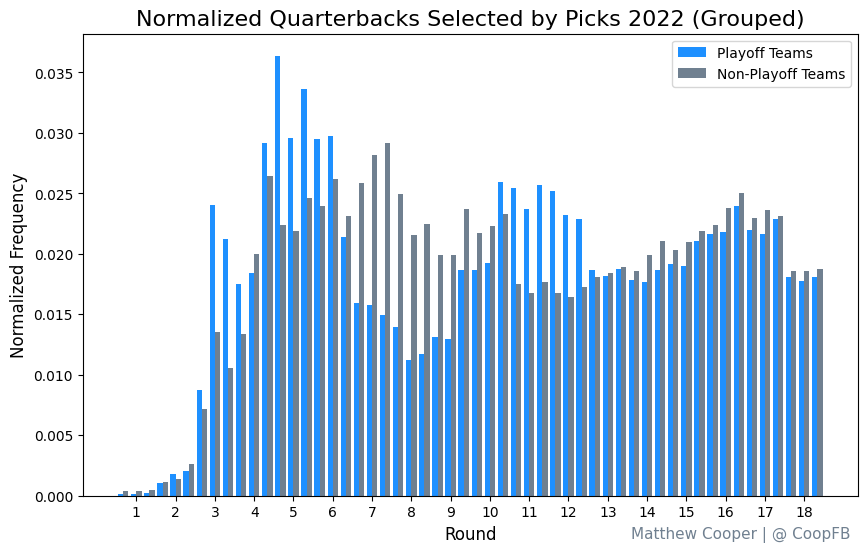

In [11]:
# Calculate the total number of playoff and non-playoff teams
total_playoff_teams = sum(playoff_freq)
total_non_playoff_teams = sum(non_playoff_freq)

# Normalize the frequencies
normalized_playoff_freq = playoff_freq / total_playoff_teams
normalized_non_playoff_freq = non_playoff_freq / total_non_playoff_teams

# Group the frequencies by every four picks
grouped_playoff_freq = np.array([sum(normalized_playoff_freq[i:i+4]) for i in range(0, len(x), 4)])
grouped_non_playoff_freq = np.array([sum(normalized_non_playoff_freq[i:i+4]) for i in range(0, len(x), 4)])

# Create the desired figure and plot bars for playoff and non-playoff teams
plt.figure(figsize=(10, 6))
grouped_x = np.arange(1, len(grouped_playoff_freq) + 1)
bar_width = 0.4 
plt.bar(grouped_x - bar_width/2, grouped_playoff_freq, width=bar_width, label='Playoff Teams', color='dodgerblue')
plt.bar(grouped_x + bar_width/2, grouped_non_playoff_freq, width=bar_width, label='Non-Playoff Teams', color='slategray')

# Set the x-axis ticks and labels
selected_ticks = np.arange(2, len(grouped_x) + 1, 3)
labels = [str(i) for i in range(1, 19)]
plt.xticks(selected_ticks, labels)

# Set the axis labels, title, legend
plt.xlabel('Round', fontsize=12)
plt.ylabel('Normalized Frequency', fontsize=12)
plt.title('Normalized Quarterbacks Selected by Picks 2022 (Grouped)', size=16)
plt.legend()

# Add name and show plot
plt.text(0.99, -0.1, name, ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=11, color='slategray')
#plt.savefig('qb_selections_22.png', facecolor='white')
plt.show()

Unlike the roster composition section, we now find a significant difference in the strategy between playoff and non-playoff teams. 

Playoff teams drafted early quarterbacks at a much higher rate than non-playoff teams. Instead of drafting a quarterback in this early window, non-playoff teams drafted many quarterbacks in a mid-round window (late round 6 to round 10), which appears almost to act as a "quarterback dead-zone."

Playoff team quarterback selection again spiked above that of non-playoff teams in a late-round window (late round 10 to late round 12) before both playoff and non-playoff teams followed a similar trend in the very late draft window (rounds 13-18). 

Given these results, we can define four quarterback draft windows: the **early-round window** (up to round 6), the **mid-round window** (rounds 7-10), the **late-round window** (rounds 10-12), and the **very-late round window** (rounds 13-18). 

The evidence from the above graph suggests that, for making the playoffs, teams should draft a quarterback in the early round window. Additionally, the data potentially suggests the late window for quarterback upside. In the next section of this project, I will look more specifically at both the early and late quarterback windows.

## Getting a "Stud": An Investigation into Early Quarterback Drafting

BBMIII data suggested that drafting a quarterback in the early parts of the draft (up to round 6) can be effective for making the playoffs. So what can we learn about how to best draft a quarterback in this range?

Inspired by this twitter thread from Sam Hoppen and Hayden Winks (https://twitter.com/SamHoppen/status/1665527899934412802?s=20), I decided to look at the effect of drafting a quarterback **before/at/after** their ADP in this early round range.

In [35]:
# Sum QB points for each team
qb_points = qbs_22.groupby('tournament_entry_id').agg(qb_points=('pick_points', 'sum'))

# Filter qbs_22 dataset to only include early round QBs
early_qbs = qbs_22[(qbs_22['team_pick_number'] >= 2) & (qbs_22['team_pick_number'] <= 6)]
early_qbs = early_qbs[['tournament_entry_id', 'player_name', 'position_name', 'projection_adp', 'overall_pick_number', 'team_pick_number', 'roster_points']]

# Merge the two datasets and add columns for making the playoffs & ADP/Draft Position difference
early_qbs = pd.merge(early_qbs, qb_points, on='tournament_entry_id', how='left')
early_qbs['adp_difference'] = early_qbs['overall_pick_number'] - early_qbs['projection_adp']
early_qbs['made_playoffs'] = 0
early_qbs['made_playoffs'] = early_qbs['tournament_entry_id'].apply(is_postseason)


early_qbs.head()

tournament_entry_id      player_name position_name  \
0  da8a102a-ad58-42e8-b46e-03382ed0923b   Justin Herbert            QB   
1  1b97a0e5-3a29-4a28-b276-69541afe116f       Trey Lance            QB   
2  b65930ef-39d3-463b-84e1-fa5b6d05e40c       Josh Allen            QB   
3  a26bdf98-1180-499a-8a5f-83bc51411fd6  Patrick Mahomes            QB   
4  0e92232b-a16b-42fd-a18a-e9d956b68654       Joe Burrow            QB   

   projection_adp  overall_pick_number  team_pick_number  roster_points  \
0           45.28                   46                 4        1147.44   
1           70.08                   71                 6        1561.00   
2           31.72                   32                 3        1680.26   
3           50.65                   53                 5        1493.08   
4           75.19                   66                 6        1467.62   

   qb_points  adp_difference  made_playoffs  
0     250.08            0.72              0  
1     116.54            0.92              0  
2     357.46            0.28              1  
3     341.28            2.35              0  
4     375.32           -9.19              0

I filtered all quarterbacks selected between rounds 2 and 6 (no quarterbacks had higher than a second-round ADP last year).

In [36]:
outlier_threshold = 50
filtered_early_qbs = early_qbs[abs(early_qbs['adp_difference']) <= outlier_threshold]
filtered_early_qbs.head()

tournament_entry_id      player_name position_name  \
0  da8a102a-ad58-42e8-b46e-03382ed0923b   Justin Herbert            QB   
1  1b97a0e5-3a29-4a28-b276-69541afe116f       Trey Lance            QB   
2  b65930ef-39d3-463b-84e1-fa5b6d05e40c       Josh Allen            QB   
3  a26bdf98-1180-499a-8a5f-83bc51411fd6  Patrick Mahomes            QB   
4  0e92232b-a16b-42fd-a18a-e9d956b68654       Joe Burrow            QB   

   projection_adp  overall_pick_number  team_pick_number  roster_points  \
0           45.28                   46                 4        1147.44   
1           70.08                   71                 6        1561.00   
2           31.72                   32                 3        1680.26   
3           50.65                   53                 5        1493.08   
4           75.19                   66                 6        1467.62   

   qb_points  adp_difference  made_playoffs  
0     250.08            0.72              0  
1     116.54            0.92              0  
2     357.46            0.28              1  
3     341.28            2.35              0  
4     375.32           -9.19              0

To remove outliers, any player selected 50+ picks before their ADP was removed from the dataset.

X does not have valid feature names, but LinearRegression was fitted with feature names


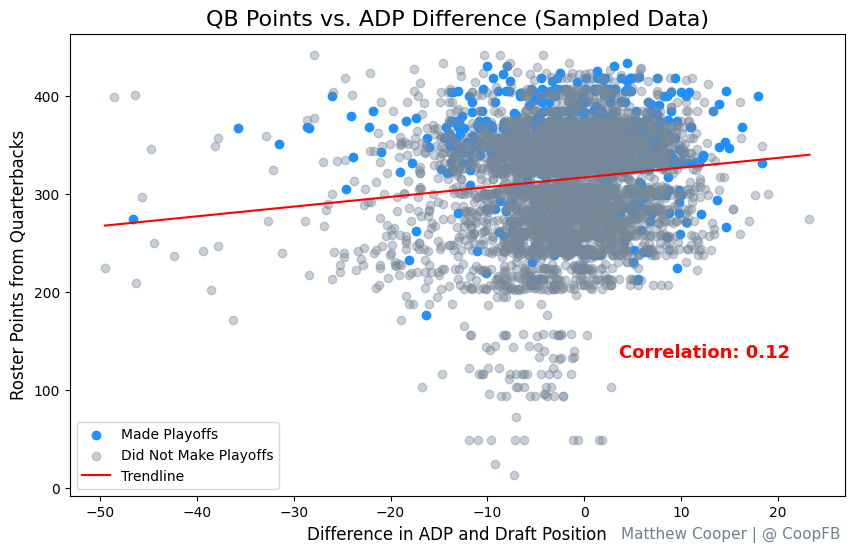

In [43]:
# Perform random sampling from the df
sample_size = 5000
sampled_data = filtered_early_qbs.sample(n=sample_size, replace=True)

# Separate the data for teams that made playoffs and teams that didn't
made_playoffs_data = sampled_data[sampled_data['made_playoffs'] == 1]
did_not_make_playoffs_data = sampled_data[sampled_data['made_playoffs'] == 0]

# Create the scatter plot and plot points for playoff and non-playoff teams
plt.figure(figsize=(10, 6))
plt.scatter(made_playoffs_data['adp_difference'], made_playoffs_data['qb_points'], color='dodgerblue', label='Made Playoffs')
plt.scatter(did_not_make_playoffs_data['adp_difference'], did_not_make_playoffs_data['qb_points'], color='lightslategray', label='Did Not Make Playoffs', alpha=0.4)

# Fit a linear regression model to the entire dataset
model = LinearRegression()
model.fit(sampled_data[['adp_difference']], sampled_data['qb_points'])

# Generate x-values for the trendline and plot it
x = np.linspace(sampled_data['adp_difference'].min(), sampled_data['adp_difference'].max(), 100)
plt.plot(x, model.predict(x.reshape(-1, 1)), color='red', label='Trendline')

# Calculate the correlation coefficient and add to plot
corr_coeff = np.corrcoef(sampled_data['adp_difference'], sampled_data['qb_points'])[0, 1]
plt.text(0.93, 0.3, f'Correlation: {corr_coeff:.2f}', transform=plt.gca().transAxes, ha='right', fontsize=13, fontweight='heavy', color='red')

# Set plot title and axis labels
plt.title('QB Points vs. ADP Difference (Sampled Data)', size=16)
plt.xlabel('Difference in ADP and Draft Position', fontsize=12)
plt.ylabel('Roster Points from Quarterbacks', fontsize=12)
plt.text(0.995, -0.1, name, ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=11, color='slategray')

# Add legend and show plot
plt.legend(loc='lower left')
# plt.savefig('early_qb_adp_22.png', dpi=300, facecolor='white')
plt.show()

The above graph shows a random sample of 5000 teams' quarterbacks and the relation between the team's **roster points from quarterbacks** and the **difference in draft position and ADP** for the quarterback. After many trial samples, the correlation between these two variables hovers around ~0.12, meaning that drafting a quarterback closer to or after their ADP slightly correlated with an increase in overall QB production. We can see that most teams who drafted a quarterback 20-50 picks before their ADP did **NOT** make the playoffs. The largest concentration of playoff teams drafted their early-round quarterback within 15 picks of their ADP.

My main takeaway from this information: When drafting an early-round quarterback, don't reach TOO far. The closer to their ADP (or past it) that you can draft these quarterbacks, the better. Community-wide ADP gives a mostly accurate prediction for these quarterbacks, so "outsmarting" and reaching far on an elite quarterback early can hinder playoff probability.

## An Investigation into Late-Round Quarterback Drafting

Now that we have looked into some strategy for drafting an early-round quarterback, I turned my focus onto the late-round section. Given the spike in playoff-team drafting in rounds 10-12, I investigated the meaning behind this pick: Waiting on first quarterback or drafting a backup?

To do this, I re-made the normalized quarterbacks selected by pick visualization, only including the **first** quarterback selected by each team. In doing so, it will be possible to evaluate whether or not a significant proportion of playoff teams waited until round 9+ to draft their first quarterback.

In [22]:
# Count number of quarterbacks taken at each pick for playoff and non-playoff teams
first_qbs_22 = qbs_22.groupby('tournament_entry_id')['overall_pick_number'].min().reset_index()
first_qbs_22['playoff_team'] = first_qbs_22['tournament_entry_id'].isin(postseason_teams).astype(int)
first_qb_counts = first_qbs_22.groupby(['overall_pick_number', 'playoff_team']).size().unstack(fill_value=0)

# Normalize the counts
normalized_counts = first_qb_counts.div(first_qb_counts.sum(axis=0), axis=1)
normalized_counts.head()

playoff_team                0         1
overall_pick_number                    
1                    0.000269  0.000080
2                    0.000237  0.000106
3                    0.000231  0.000093
4                    0.000247  0.000106
5                    0.000242  0.000146

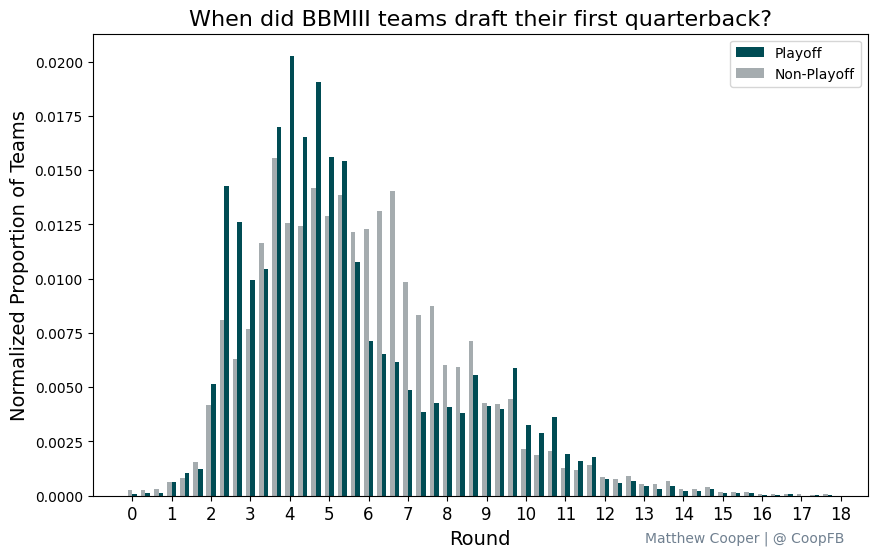

In [24]:
# Create bins for each four picks
bins = pd.cut(normalized_counts.index, bins=54)

# Group the data by the bins and calculate the mean value for each bin
grouped_normalized_counts = normalized_counts.groupby(bins).mean()

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# X-axis ticks and labels
x = np.arange(len(grouped_normalized_counts))
bar_width = 0.35
ticks = list(range(0, 55, 3))
labels = list(range(19))
ax.set_xticks(ticks) 
ax.set_xticklabels(labels, fontsize=12)

# Plot the bars for playoff and non-playoff teams
ax.bar(x + bar_width/2, grouped_normalized_counts[1], width=bar_width, label='Playoff', color='#004C54')
ax.bar(x - bar_width/2, grouped_normalized_counts[0], width=bar_width, label='Non-Playoff', color='#A5ACAF')

# Set axis labels, title, and legend
ax.set_xlabel('Round', fontsize=14)
ax.set_ylabel('Normalized Proportion of Teams', fontsize=14)
ax.set_title('When did BBMIII teams draft their first quarterback?', fontsize=16)
ax.legend()

# Add name and show plot
plt.text(0.97, -0.1, name, transform=ax.transAxes, horizontalalignment='right', color='slategray')
# plt.savefig('first_qb_drafted_22.png', dpi=300, facecolor='white')
plt.show()

From the above figure, it's clear that a majority of playoff teams did **not** wait until rounds 9+ to draft their first quarterback. However, a higher proportion of playoff teams did use this strategy as opposed to non-playoff teams, somewhat validating the strategy. Especially in a draft where a team is not in a position to draft one of the early quarterbacks, waiting until rounds 9+ would be a viable strategy according to the data.

As such, the main takeaway from this information is that drafting an elite quarterback early is still the primary success strategy for making the playoffs, though value can be found in later rounds.

## The 'Why': What to Look for When You DO Decide to Draft

Given all of the previous analysis on draft strategies, it is finally time to look at specific traits of quarterbacks that can be predictive of team success. In order to do this, I created a model. As with the rest of the project, we will define 'success' in this case as making the playoffs.

In [32]:
# Group quarterbacks by team and sort by pick order
advanced = qbs_22
advanced['pick_order'] = advanced.groupby('tournament_entry_id')['team_pick_number'].rank(method='first').astype(int)

# Create a pivot table to be able to create desired dataframe
adv_pivot = advanced.pivot(index='tournament_entry_id', columns='pick_order', values='player_name')

adv_pivot.columns = ['player_{}'.format(col) for col in adv_pivot.columns]
adv_pivot.reset_index(inplace=True)

selected_columns = ['tournament_entry_id', 'player_1', 'player_2', 'player_3']
features = adv_pivot[selected_columns]
features.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


tournament_entry_id      player_1        player_2  \
0  0000146a-e245-49c3-8a4e-8e739cfe1e46    Josh Allen    Daniel Jones   
1  0000225d-54fa-4334-aa1e-41e7adaa2542   Jalen Hurts    Kirk Cousins   
2  00003d67-9d4b-47ad-a8a4-d3856480a821  Dak Prescott     Davis Mills   
3  00004939-5e99-4dfb-b597-d6463eacf6aa    Josh Allen  Deshaun Watson   
4  0000766d-7308-495e-ad86-6ddb69dbc3ab  Dak Prescott    Daniel Jones   

          player_3  
0              NaN  
1  Trevor Lawrence  
2              NaN  
3     Malik Willis  
4   Ryan Tannehill

I grouped BBMIII quarterback data by team and their drafted quarterbacks. Next, I created a specific set of features for each team and quarterback, including a mix of stats and roster composition information.

In [33]:
# Adding column for drafting a third quarterback
features['qb_3_drafted'] = features['player_3'].notna().astype(int)

# Adding a column for making the playoffs (label)
features['made_playoffs'] = features['tournament_entry_id'].apply(is_postseason)

# Add qb1 points
features = pd.merge(features, qbs_22[['tournament_entry_id', 'player_name', 'pick_points']], 
                    left_on=['tournament_entry_id', 'player_1'], 
                    right_on=['tournament_entry_id', 'player_name'], 
                    how='left')
features.drop('player_name', axis=1, inplace=True)
features = features.rename(columns={'pick_points': 'qb_1_points'})

# Add qb2 points
features = pd.merge(features, qbs_22[['tournament_entry_id', 'player_name', 'pick_points']], 
                    left_on=['tournament_entry_id', 'player_2'], 
                    right_on=['tournament_entry_id', 'player_name'], 
                    how='left')
features.drop('player_name', axis=1, inplace=True)
features = features.rename(columns={'pick_points': 'qb_2_points'})

features.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


tournament_entry_id      player_1        player_2  \
0  0000146a-e245-49c3-8a4e-8e739cfe1e46    Josh Allen    Daniel Jones   
1  0000225d-54fa-4334-aa1e-41e7adaa2542   Jalen Hurts    Kirk Cousins   
2  00003d67-9d4b-47ad-a8a4-d3856480a821  Dak Prescott     Davis Mills   
3  00004939-5e99-4dfb-b597-d6463eacf6aa    Josh Allen  Deshaun Watson   
4  0000766d-7308-495e-ad86-6ddb69dbc3ab  Dak Prescott    Daniel Jones   

          player_3  qb_3_drafted  made_playoffs  qb_1_points  qb_2_points  
0              NaN             0              0       296.42        72.52  
1  Trevor Lawrence             1              1       290.60         0.00  
2              NaN             0              0       118.54        89.16  
3     Malik Willis             1              1       325.92         0.00  
4   Ryan Tannehill             1              0        82.24       135.46

We now have our labels and features like points for each quarterback. I next added features for the number of stacked players with each roster's first two quarterbacks drafted.

In [34]:
# Finding players and their corresponding teams for 2022 season
offensive_positions = ['QB', 'RB', 'WR', 'TE']
rosters = rosters[rosters['depth_chart_position'].isin(offensive_positions)]
rosters = rosters[rosters['status'] != 'Practice Squad']

# Merging draft data with roster information
reg_teams_22 = pd.merge(reg_22, rosters[['player_name', 'team']], on='player_name', how='left')

# Finding players who have no team (didn't merge properly)
na_teams = reg_teams_22[pd.isna(reg_teams_22['team'])]
names = set(na_teams['player_name'])

# Fixing teams for names that didn't work (Only doing relevant names)
reg_teams_22.loc[reg_teams_22['player_name'] == 'AJ Dillon', 'team'] = 'GB'
reg_teams_22.loc[reg_teams_22['player_name'] == 'DJ Chark', 'team'] = 'DET'
reg_teams_22.loc[reg_teams_22['player_name'] == 'DJ Moore', 'team'] = 'CHI'
reg_teams_22.loc[reg_teams_22['player_name'] == 'Darrell Henderson', 'team'] = 'LAR'
reg_teams_22.loc[reg_teams_22['player_name'] == 'Jeff Wilson', 'team'] = 'SF'
reg_teams_22.loc[reg_teams_22['player_name'] == 'Joshua Palmer', 'team'] = 'LAC'
reg_teams_22.loc[reg_teams_22['player_name'] == 'KJ Hamler', 'team'] = 'MIN'
reg_teams_22.head()

# Determining number of stacks for each NFL team for every BBMIII roster (QBs on roster do not count)
mask = reg_teams_22['position_name'] != 'QB'
stack_counts = reg_teams_22[mask].groupby(['tournament_entry_id', 'team']).size().reset_index(name='num_stacks')

# Merging stack data back into BBMIII draft data
stacks_22 = pd.merge(reg_teams_22, stack_counts, on=['team', 'tournament_entry_id'], how='left')
stacks_22.loc[mask, 'num_stacks'] = 0
stacks_22['num_stacks'].fillna(0, inplace=True)
stacks_22['num_stacks'] = stacks_22['num_stacks'].astype(int)

stacks_22[stacks_22['position_name'] == 'QB'].head()

draft_id                  draft_time  clock  \
8   d4e1b2c6-26e0-48ec-a2e9-ca4d43f00ade  2022-08-27 05:38:33.558728     30   
9   d4e1b2c6-26e0-48ec-a2e9-ca4d43f00ade  2022-08-27 05:38:33.558728     30   
16  d4e1b2c6-26e0-48ec-a2e9-ca4d43f00ade  2022-08-27 05:38:33.558728     30   
24  d4e1b2c6-26e0-48ec-a2e9-ca4d43f00ade  2022-08-27 05:38:33.558728     30   
31  d4e1b2c6-26e0-48ec-a2e9-ca4d43f00ade  2022-08-27 05:38:33.558728     30   

                          draft_entry_id  \
8   6c505321-ae39-466a-ace2-1445ed993a45   
9   7336d518-d05e-4f45-9229-f61e24c0b6d3   
16  7772b5e5-8119-4f5e-b450-fa3457726f9a   
24  7772b5e5-8119-4f5e-b450-fa3457726f9a   
31  1f91a25a-5b18-4398-b3d1-af9f3d6ae177   

                     tournament_entry_id  \
8   0e92232b-a16b-42fd-a18a-e9d956b68654   
9   6408bcff-e8a1-4d9b-a001-2a75106c613a   
16  da8a102a-ad58-42e8-b46e-03382ed0923b   
24  da8a102a-ad58-42e8-b46e-03382ed0923b   
31  3dbd518d-b70d-469a-b722-ca9d7d76c351   

         tournament_round_draft_entry_id  tournament_round_number  \
8   1a91ea08-f183-4338-ae82-4f94290af4a4                        1   
9   ec3b5930-e7f4-47e8-ad17-3bb430a16525                        1   
16  843ccdc8-3141-489f-ad66-ba732b2e634e                        1   
24  843ccdc8-3141-489f-ad66-ba732b2e634e                        1   
31  1a0d54b3-9a13-4fa1-a48b-db7c68319bf3                        1   

       player_name position_name  bye_week  projection_adp  pick_order  \
8    Justin Fields            QB        14          132.85           7   
9    Aaron Rodgers            QB        14          111.02          10   
16  Ryan Tannehill            QB         6          186.10           3   
24  Justin Herbert            QB         8           45.28           3   
31       Tom Brady            QB        11           87.90          11   

    overall_pick_number  team_pick_number  pick_points  roster_points  \
8                   127                11       109.14        1467.62   
9                   106                 9       191.56        1491.90   
16                  195                17        39.16        1147.44   
24                   46                 4       210.92        1147.44   
31                   86                 8       107.60        1605.82   

    playoff_team team  num_stacks  
8              0  CHI           2  
9              0   GB           1  
16             0  TEN           2  
24             0  LAC           0  
31             0   TB           2

In [20]:
# Add QB1 Stacks
temp_features = pd.merge(features, stacks_22[['tournament_entry_id', 'player_name', 'num_stacks']], 
                    left_on=['player_1', 'tournament_entry_id'], 
                    right_on=['player_name', 'tournament_entry_id'],
                    how='left')
temp_features.drop('player_name', axis=1, inplace=True)
temp_features = temp_features.rename(columns={'num_stacks': 'qb_1_stacks'})

# Add QB2 Stacks
new_features = pd.merge(temp_features, stacks_22[['tournament_entry_id', 'player_name', 'num_stacks']], 
                    left_on=['player_2', 'tournament_entry_id'], 
                    right_on=['player_name', 'tournament_entry_id'],
                    how='left')
new_features.drop('player_name', axis=1, inplace=True)
new_features = new_features.rename(columns={'num_stacks': 'qb_2_stacks'})
new_features['qb_2_stacks'].fillna(0, inplace=True)
new_features['qb_2_stacks'] = new_features['qb_2_stacks'].astype(int)
new_features.head()

tournament_entry_id      player_1        player_2  \
0  0000146a-e245-49c3-8a4e-8e739cfe1e46    Josh Allen    Daniel Jones   
1  0000225d-54fa-4334-aa1e-41e7adaa2542   Jalen Hurts    Kirk Cousins   
2  00003d67-9d4b-47ad-a8a4-d3856480a821  Dak Prescott     Davis Mills   
3  00004939-5e99-4dfb-b597-d6463eacf6aa    Josh Allen  Deshaun Watson   
4  0000766d-7308-495e-ad86-6ddb69dbc3ab  Dak Prescott    Daniel Jones   

          player_3  qb_3_drafted  made_playoffs  qb_1_points  qb_2_points  \
0              NaN             0              0       296.42        72.52   
1  Trevor Lawrence             1              1       290.60         0.00   
2              NaN             0              0       118.54        89.16   
3     Malik Willis             1              1       325.92         0.00   
4   Ryan Tannehill             1              0        82.24       135.46   

   qb_1_stacks  qb_2_stacks  
0            2            0  
1            2            1  
2            1            0  
3            1            0  
4            0            0

With information about stacks included, I added features for important passing stats. Below is the code for adding features on EPA/dropback, air yards, sacks, and interceptions.

In [22]:
# Filter pbp data to only include rushing and passing plays
pbp_rp = pbp_22[(pbp_22['pass'] == 1) | (pbp_22['rush'] == 1)]
pbp_rp = pbp_rp[pbp_rp['season_type'] == 'REG']

# Filter to dropbacks only for EPA
dropbacks_22 = pbp_rp[pbp_rp['qb_dropback'] == 1]

min_dropbacks = 1

filtered_dropbacks = dropbacks_22.groupby('passer_player_name').filter(lambda x: len(x) >= min_dropbacks)

# Get each players EPA/dropback
pass_epa = filtered_dropbacks.groupby('passer_player_name')['epa'].mean().reset_index().rename(columns={'epa': 'epa/dropback'})

# Fix name discrepancies between pbp data and BBMIII data
pass_epa.loc[pass_epa['passer_player_name'] == 'A.Dalton', 'passer_player_name'] = 'Andy Dalton'
pass_epa.loc[pass_epa['passer_player_name'] == 'A.Rodgers', 'passer_player_name'] = 'Aaron Rodgers'
pass_epa.loc[pass_epa['passer_player_name'] == 'B.Mayfield', 'passer_player_name'] = 'Baker Mayfield'
pass_epa.loc[pass_epa['passer_player_name'] == 'C.Wentz', 'passer_player_name'] = 'Carson Wentz'
pass_epa.loc[pass_epa['passer_player_name'] == 'D.Carr', 'passer_player_name'] = 'Derek Carr'
pass_epa.loc[pass_epa['passer_player_name'] == 'D.Jones', 'passer_player_name'] = 'Daniel Jones'
pass_epa.loc[pass_epa['passer_player_name'] == 'D.Mills', 'passer_player_name'] = 'Davis Mills'
pass_epa.loc[pass_epa['passer_player_name'] == 'D.Prescott', 'passer_player_name'] = 'Dak Prescott'
pass_epa.loc[pass_epa['passer_player_name'] == 'G.Smith', 'passer_player_name'] = 'Geno Smith'
pass_epa.loc[pass_epa['passer_player_name'] == 'J.Allen', 'passer_player_name'] = 'Josh Allen'
pass_epa.loc[pass_epa['passer_player_name'] == 'J.Brissett', 'passer_player_name'] = 'Jacoby Brissett'
pass_epa.loc[pass_epa['passer_player_name'] == 'J.Burrow', 'passer_player_name'] = 'Joe Burrow'
pass_epa.loc[pass_epa['passer_player_name'] == 'J.Fields', 'passer_player_name'] = 'Justin Fields'
pass_epa.loc[pass_epa['passer_player_name'] == 'J.Flacco', 'passer_player_name'] = 'Joe Flacco'
pass_epa.loc[pass_epa['passer_player_name'] == 'J.Garoppolo', 'passer_player_name'] = 'Jimmy Garoppolo'
pass_epa.loc[pass_epa['passer_player_name'] == 'J.Goff', 'passer_player_name'] = 'Jared Goff'
pass_epa.loc[pass_epa['passer_player_name'] == 'J.Herbert', 'passer_player_name'] = 'Justin Herbert'
pass_epa.loc[pass_epa['passer_player_name'] == 'J.Hurts', 'passer_player_name'] = 'Jalen Hurts'
pass_epa.loc[pass_epa['passer_player_name'] == 'K.Cousins', 'passer_player_name'] = 'Kirk Cousins'
pass_epa.loc[pass_epa['passer_player_name'] == 'K.Murray', 'passer_player_name'] = 'Kyler Murray'
pass_epa.loc[pass_epa['passer_player_name'] == 'K.Pickett', 'passer_player_name'] = 'Kenny Pickett'
pass_epa.loc[pass_epa['passer_player_name'] == 'L.Jackson', 'passer_player_name'] = 'Lamar Jackson'
pass_epa.loc[pass_epa['passer_player_name'] == 'M.Jones', 'passer_player_name'] = 'Mac Jones'
pass_epa.loc[pass_epa['passer_player_name'] == 'M.Mariota', 'passer_player_name'] = 'Marcus Mariota'
pass_epa.loc[pass_epa['passer_player_name'] == 'M.Ryan', 'passer_player_name'] = 'Matt Ryan'
pass_epa.loc[pass_epa['passer_player_name'] == 'M.Stafford', 'passer_player_name'] = 'Matthew Stafford'
pass_epa.loc[pass_epa['passer_player_name'] == 'P.Mahomes', 'passer_player_name'] = 'Patrick Mahomes'
pass_epa.loc[pass_epa['passer_player_name'] == 'R.Tannehill', 'passer_player_name'] = 'Ryan Tannehill'
pass_epa.loc[pass_epa['passer_player_name'] == 'R.Wilson', 'passer_player_name'] = 'Russell Wilson'
pass_epa.loc[pass_epa['passer_player_name'] == 'T.Brady', 'passer_player_name'] = 'Tom Brady'
pass_epa.loc[pass_epa['passer_player_name'] == 'T.Heinicke', 'passer_player_name'] = 'Taylor Heinicke'
pass_epa.loc[pass_epa['passer_player_name'] == 'T.Lawrence', 'passer_player_name'] = 'Trevor Lawrence'
pass_epa.loc[pass_epa['passer_player_name'] == 'T.Tagovailoa', 'passer_player_name'] = 'Tua Tagovailoa'
pass_epa.loc[pass_epa['passer_player_name'] == 'Z.Wilson', 'passer_player_name'] = 'Zach Wilson'
pass_epa.loc[pass_epa['passer_player_name'] == 'T.Lance', 'passer_player_name'] = 'Trey Lance'
pass_epa.loc[pass_epa['passer_player_name'] == 'J.Winston', 'passer_player_name'] = 'Jameis Winston'
pass_epa.loc[pass_epa['passer_player_name'] == 'D.Watson', 'passer_player_name'] = 'Deshaun Watson'
pass_epa.loc[pass_epa['passer_player_name'] == 'M.Willis', 'passer_player_name'] = 'Malik Willis'
pass_epa.loc[pass_epa['passer_player_name'] == 'M.Trubisky', 'passer_player_name'] = 'Mitch Trubisky'
pass_epa.loc[pass_epa['passer_player_name'] == 'D.Ridder', 'passer_player_name'] = 'Desmond Ridder'

# Merge in EPA/Dropback data
temp_features_2 = pd.merge(new_features, pass_epa, 
                    left_on=['player_1'], 
                    right_on=['passer_player_name'],
                    how='left')
temp_features_2.drop('passer_player_name', axis=1, inplace=True)
temp_features_2 = temp_features_2.rename(columns={'epa/dropback': 'qb_1_epa_dropback'})

features_epa = pd.merge(temp_features_2, pass_epa, 
                    left_on=['player_2'], 
                    right_on=['passer_player_name'],
                    how='left')
features_epa.drop('passer_player_name', axis=1, inplace=True)
features_epa = features_epa.rename(columns={'epa/dropback': 'qb_2_epa_dropback'})


features_epa['qb_1_epa_dropback'].fillna(0, inplace=True)
features_epa['qb_2_epa_dropback'].fillna(0, inplace=True)

# Get each quarterbacks air yards/pass on pass plays only
passes_22 = pbp_rp[pbp_rp['pass'] == 1]
air_yards = passes_22.groupby('passer_player_name')['air_yards'].mean().reset_index()

# Fixing names (again)
air_yards.loc[air_yards['passer_player_name'] == 'A.Dalton', 'passer_player_name'] = 'Andy Dalton'
air_yards.loc[air_yards['passer_player_name'] == 'A.Rodgers', 'passer_player_name'] = 'Aaron Rodgers'
air_yards.loc[air_yards['passer_player_name'] == 'B.Mayfield', 'passer_player_name'] = 'Baker Mayfield'
air_yards.loc[air_yards['passer_player_name'] == 'C.Wentz', 'passer_player_name'] = 'Carson Wentz'
air_yards.loc[air_yards['passer_player_name'] == 'D.Carr', 'passer_player_name'] = 'Derek Carr'
air_yards.loc[air_yards['passer_player_name'] == 'D.Jones', 'passer_player_name'] = 'Daniel Jones'
air_yards.loc[air_yards['passer_player_name'] == 'D.Mills', 'passer_player_name'] = 'Davis Mills'
air_yards.loc[air_yards['passer_player_name'] == 'D.Prescott', 'passer_player_name'] = 'Dak Prescott'
air_yards.loc[air_yards['passer_player_name'] == 'G.Smith', 'passer_player_name'] = 'Geno Smith'
air_yards.loc[air_yards['passer_player_name'] == 'J.Allen', 'passer_player_name'] = 'Josh Allen'
air_yards.loc[air_yards['passer_player_name'] == 'J.Brissett', 'passer_player_name'] = 'Jacoby Brissett'
air_yards.loc[air_yards['passer_player_name'] == 'J.Burrow', 'passer_player_name'] = 'Joe Burrow'
air_yards.loc[air_yards['passer_player_name'] == 'J.Fields', 'passer_player_name'] = 'Justin Fields'
air_yards.loc[air_yards['passer_player_name'] == 'J.Flacco', 'passer_player_name'] = 'Joe Flacco'
air_yards.loc[air_yards['passer_player_name'] == 'J.Garoppolo', 'passer_player_name'] = 'Jimmy Garoppolo'
air_yards.loc[air_yards['passer_player_name'] == 'J.Goff', 'passer_player_name'] = 'Jared Goff'
air_yards.loc[air_yards['passer_player_name'] == 'J.Herbert', 'passer_player_name'] = 'Justin Herbert'
air_yards.loc[air_yards['passer_player_name'] == 'J.Hurts', 'passer_player_name'] = 'Jalen Hurts'
air_yards.loc[air_yards['passer_player_name'] == 'K.Cousins', 'passer_player_name'] = 'Kirk Cousins'
air_yards.loc[air_yards['passer_player_name'] == 'K.Murray', 'passer_player_name'] = 'Kyler Murray'
air_yards.loc[air_yards['passer_player_name'] == 'K.Pickett', 'passer_player_name'] = 'Kenny Pickett'
air_yards.loc[air_yards['passer_player_name'] == 'L.Jackson', 'passer_player_name'] = 'Lamar Jackson'
air_yards.loc[air_yards['passer_player_name'] == 'M.Jones', 'passer_player_name'] = 'Mac Jones'
air_yards.loc[air_yards['passer_player_name'] == 'M.Mariota', 'passer_player_name'] = 'Marcus Mariota'
air_yards.loc[air_yards['passer_player_name'] == 'M.Ryan', 'passer_player_name'] = 'Matt Ryan'
air_yards.loc[air_yards['passer_player_name'] == 'M.Stafford', 'passer_player_name'] = 'Matthew Stafford'
air_yards.loc[air_yards['passer_player_name'] == 'P.Mahomes', 'passer_player_name'] = 'Patrick Mahomes'
air_yards.loc[air_yards['passer_player_name'] == 'R.Tannehill', 'passer_player_name'] = 'Ryan Tannehill'
air_yards.loc[air_yards['passer_player_name'] == 'R.Wilson', 'passer_player_name'] = 'Russell Wilson'
air_yards.loc[air_yards['passer_player_name'] == 'T.Brady', 'passer_player_name'] = 'Tom Brady'
air_yards.loc[air_yards['passer_player_name'] == 'T.Heinicke', 'passer_player_name'] = 'Taylor Heinicke'
air_yards.loc[air_yards['passer_player_name'] == 'T.Lawrence', 'passer_player_name'] = 'Trevor Lawrence'
air_yards.loc[air_yards['passer_player_name'] == 'T.Tagovailoa', 'passer_player_name'] = 'Tua Tagovailoa'
air_yards.loc[air_yards['passer_player_name'] == 'Z.Wilson', 'passer_player_name'] = 'Zach Wilson'
air_yards.loc[air_yards['passer_player_name'] == 'T.Lance', 'passer_player_name'] = 'Trey Lance'
air_yards.loc[air_yards['passer_player_name'] == 'J.Winston', 'passer_player_name'] = 'Jameis Winston'
air_yards.loc[air_yards['passer_player_name'] == 'D.Watson', 'passer_player_name'] = 'Deshaun Watson'
air_yards.loc[air_yards['passer_player_name'] == 'M.Willis', 'passer_player_name'] = 'Malik Willis'
air_yards.loc[air_yards['passer_player_name'] == 'M.Trubisky', 'passer_player_name'] = 'Mitch Trubisky'
air_yards.loc[air_yards['passer_player_name'] == 'D.Ridder', 'passer_player_name'] = 'Desmond Ridder'


# Merge in Air Yards / Pass data
temp_features_3 = pd.merge(features_epa, air_yards, 
                    left_on=['player_1'], 
                    right_on=['passer_player_name'],
                    how='left')
temp_features_3.drop('passer_player_name', axis=1, inplace=True)
temp_features_3 = temp_features_3.rename(columns={'air_yards': 'qb_1_air_yards'})

features_air = pd.merge(temp_features_3, air_yards, 
                    left_on=['player_2'], 
                    right_on=['passer_player_name'],
                    how='left')
features_air.drop('passer_player_name', axis=1, inplace=True)
features_air = features_air.rename(columns={'air_yards': 'qb_2_air_yards'})


features_air['qb_1_air_yards'].fillna(0, inplace=True)
features_air['qb_2_air_yards'].fillna(0, inplace=True)

# Group data to get number of sacks taken and interceptions thrown in 2022
extras = dropbacks_22.groupby('passer_player_name').agg({'sack' : 'sum', 'interception' : 'sum'}).reset_index()

# Fix names
extras.loc[extras['passer_player_name'] == 'A.Rodgers', 'passer_player_name'] = 'Aaron Rodgers'
extras.loc[extras['passer_player_name'] == 'B.Mayfield', 'passer_player_name'] = 'Baker Mayfield'
extras.loc[extras['passer_player_name'] == 'C.Wentz', 'passer_player_name'] = 'Carson Wentz'
extras.loc[extras['passer_player_name'] == 'D.Carr', 'passer_player_name'] = 'Derek Carr'
extras.loc[extras['passer_player_name'] == 'D.Jones', 'passer_player_name'] = 'Daniel Jones'
extras.loc[extras['passer_player_name'] == 'D.Mills', 'passer_player_name'] = 'Davis Mills'
extras.loc[extras['passer_player_name'] == 'D.Prescott', 'passer_player_name'] = 'Dak Prescott'
extras.loc[extras['passer_player_name'] == 'G.Smith', 'passer_player_name'] = 'Geno Smith'
extras.loc[extras['passer_player_name'] == 'J.Allen', 'passer_player_name'] = 'Josh Allen'
extras.loc[extras['passer_player_name'] == 'J.Brissett', 'passer_player_name'] = 'Jacoby Brissett'
extras.loc[extras['passer_player_name'] == 'J.Burrow', 'passer_player_name'] = 'Joe Burrow'
extras.loc[extras['passer_player_name'] == 'J.Fields', 'passer_player_name'] = 'Justin Fields'
extras.loc[extras['passer_player_name'] == 'J.Flacco', 'passer_player_name'] = 'Joe Flacco'
extras.loc[extras['passer_player_name'] == 'J.Garoppolo', 'passer_player_name'] = 'Jimmy Garoppolo'
extras.loc[extras['passer_player_name'] == 'J.Goff', 'passer_player_name'] = 'Jared Goff'
extras.loc[extras['passer_player_name'] == 'J.Herbert', 'passer_player_name'] = 'Justin Herbert'
extras.loc[extras['passer_player_name'] == 'J.Hurts', 'passer_player_name'] = 'Jalen Hurts'
extras.loc[extras['passer_player_name'] == 'K.Cousins', 'passer_player_name'] = 'Kirk Cousins'
extras.loc[extras['passer_player_name'] == 'K.Murray', 'passer_player_name'] = 'Kyler Murray'
extras.loc[extras['passer_player_name'] == 'K.Pickett', 'passer_player_name'] = 'Kenny Pickett'
extras.loc[extras['passer_player_name'] == 'L.Jackson', 'passer_player_name'] = 'Lamar Jackson'
extras.loc[extras['passer_player_name'] == 'M.Jones', 'passer_player_name'] = 'Mac Jones'
extras.loc[extras['passer_player_name'] == 'M.Mariota', 'passer_player_name'] = 'Marcus Mariota'
extras.loc[extras['passer_player_name'] == 'M.Ryan', 'passer_player_name'] = 'Matt Ryan'
extras.loc[extras['passer_player_name'] == 'M.Stafford', 'passer_player_name'] = 'Matthew Stafford'
extras.loc[extras['passer_player_name'] == 'P.Mahomes', 'passer_player_name'] = 'Patrick Mahomes'
extras.loc[extras['passer_player_name'] == 'R.Tannehill', 'passer_player_name'] = 'Ryan Tannehill'
extras.loc[extras['passer_player_name'] == 'R.Wilson', 'passer_player_name'] = 'Russell Wilson'
extras.loc[extras['passer_player_name'] == 'T.Brady', 'passer_player_name'] = 'Tom Brady'
extras.loc[extras['passer_player_name'] == 'T.Heinicke', 'passer_player_name'] = 'Taylor Heinicke'
extras.loc[extras['passer_player_name'] == 'T.Lawrence', 'passer_player_name'] = 'Trevor Lawrence'
extras.loc[extras['passer_player_name'] == 'T.Tagovailoa', 'passer_player_name'] = 'Tua Tagovailoa'
extras.loc[extras['passer_player_name'] == 'Z.Wilson', 'passer_player_name'] = 'Zach Wilson'
extras.loc[extras['passer_player_name'] == 'T.Lance', 'passer_player_name'] = 'Trey Lance'
extras.loc[extras['passer_player_name'] == 'J.Winston', 'passer_player_name'] = 'Jameis Winston'
extras.loc[extras['passer_player_name'] == 'D.Watson', 'passer_player_name'] = 'Deshaun Watson'
extras.loc[extras['passer_player_name'] == 'M.Willis', 'passer_player_name'] = 'Malik Willis'
extras.loc[extras['passer_player_name'] == 'M.Trubisky', 'passer_player_name'] = 'Mitch Trubisky'
extras.loc[extras['passer_player_name'] == 'D.Ridder', 'passer_player_name'] = 'Desmond Ridder'

# Merge in Sacks and Interceptions Data
temp_features_4 = pd.merge(features_air, extras, 
                    left_on=['player_1'], 
                    right_on=['passer_player_name'],
                    how='left')
temp_features_4.drop('passer_player_name', axis=1, inplace=True)
temp_features_4 = temp_features_4.rename(columns={'sack': 'qb_1_sacks', 'interception': 'qb_1_interceptions'})

features_extra = pd.merge(temp_features_4, extras, 
                    left_on=['player_2'], 
                    right_on=['passer_player_name'],
                    how='left')
features_extra.drop('passer_player_name', axis=1, inplace=True)
features_extra = features_extra.rename(columns={'sack': 'qb_2_sacks', 'interception': 'qb_2_interceptions'})

features_extra.head()

tournament_entry_id      player_1        player_2  \
0  0000146a-e245-49c3-8a4e-8e739cfe1e46    Josh Allen    Daniel Jones   
1  0000225d-54fa-4334-aa1e-41e7adaa2542   Jalen Hurts    Kirk Cousins   
2  00003d67-9d4b-47ad-a8a4-d3856480a821  Dak Prescott     Davis Mills   
3  00004939-5e99-4dfb-b597-d6463eacf6aa    Josh Allen  Deshaun Watson   
4  0000766d-7308-495e-ad86-6ddb69dbc3ab  Dak Prescott    Daniel Jones   

          player_3  qb_3_drafted  made_playoffs  qb_1_points  qb_2_points  \
0              NaN             0              0       296.42        72.52   
1  Trevor Lawrence             1              1       290.60         0.00   
2              NaN             0              0       118.54        89.16   
3     Malik Willis             1              1       325.92         0.00   
4   Ryan Tannehill             1              0        82.24       135.46   

   qb_1_stacks  qb_2_stacks  qb_1_epa_dropback  qb_2_epa_dropback  \
0            2            0           0.148864           0.009743   
1            2            1           0.073348           0.029093   
2            1            0           0.088990          -0.145128   
3            1            0           0.148864          -0.160520   
4            0            0           0.088990           0.009743   

   qb_1_air_yards  qb_2_air_yards  qb_1_sacks  qb_1_interceptions  qb_2_sacks  \
0        9.222615        6.492505        33.0                14.0        44.0   
1        8.117391        7.528951        38.0                 6.0        46.0   
2        8.210660        7.742678        20.0                15.0        31.0   
3        9.222615        7.226190        33.0                14.0        20.0   
4        8.210660        6.492505        20.0                15.0        44.0   

   qb_2_interceptions  
0                 5.0  
1                14.0  
2                15.0  
3                 5.0  
4                 5.0

In this next section of code, I added in features for each quarterback's rushing stats (rushing opportunities and yards).

In [23]:
# Filter to only rushing attempts for each quarterback and find total yards & attempts
qb_runs = pbp_22[(pbp_22['rush_attempt'] == 1) & (pbp_22['season_type'] == 'REG')]
rushing = qb_runs.groupby('rusher_player_name').agg({'rushing_yards' : 'sum', 'play_id' : 'size'}).reset_index()

# Fix names
rushing.loc[rushing['rusher_player_name'] == 'A.Rodgers', 'rusher_player_name'] = 'Aaron Rodgers'
rushing.loc[rushing['rusher_player_name'] == 'B.Mayfield', 'rusher_player_name'] = 'Baker Mayfield'
rushing.loc[rushing['rusher_player_name'] == 'C.Wentz', 'rusher_player_name'] = 'Carson Wentz'
rushing.loc[rushing['rusher_player_name'] == 'D.Carr', 'rusher_player_name'] = 'Derek Carr'
rushing.loc[rushing['rusher_player_name'] == 'D.Jones', 'rusher_player_name'] = 'Daniel Jones'
rushing.loc[rushing['rusher_player_name'] == 'D.Mills', 'rusher_player_name'] = 'Davis Mills'
rushing.loc[rushing['rusher_player_name'] == 'D.Prescott', 'rusher_player_name'] = 'Dak Prescott'
rushing.loc[rushing['rusher_player_name'] == 'G.Smith', 'rusher_player_name'] = 'Geno Smith'
rushing.loc[rushing['rusher_player_name'] == 'J.Allen', 'rusher_player_name'] = 'Josh Allen'
rushing.loc[rushing['rusher_player_name'] == 'J.Brissett', 'rusher_player_name'] = 'Jacoby Brissett'
rushing.loc[rushing['rusher_player_name'] == 'J.Burrow', 'rusher_player_name'] = 'Joe Burrow'
rushing.loc[rushing['rusher_player_name'] == 'J.Fields', 'rusher_player_name'] = 'Justin Fields'
rushing.loc[rushing['rusher_player_name'] == 'J.Flacco', 'rusher_player_name'] = 'Joe Flacco'
rushing.loc[rushing['rusher_player_name'] == 'J.Garoppolo', 'rusher_player_name'] = 'Jimmy Garoppolo'
rushing.loc[rushing['rusher_player_name'] == 'J.Goff', 'rusher_player_name'] = 'Jared Goff'
rushing.loc[rushing['rusher_player_name'] == 'J.Herbert', 'rusher_player_name'] = 'Justin Herbert'
rushing.loc[rushing['rusher_player_name'] == 'J.Hurts', 'rusher_player_name'] = 'Jalen Hurts'
rushing.loc[rushing['rusher_player_name'] == 'K.Cousins', 'rusher_player_name'] = 'Kirk Cousins'
rushing.loc[rushing['rusher_player_name'] == 'K.Murray', 'rusher_player_name'] = 'Kyler Murray'
rushing.loc[rushing['rusher_player_name'] == 'K.Pickett', 'rusher_player_name'] = 'Kenny Pickett'
rushing.loc[rushing['rusher_player_name'] == 'L.Jackson', 'rusher_player_name'] = 'Lamar Jackson'
rushing.loc[rushing['rusher_player_name'] == 'M.Jones', 'rusher_player_name'] = 'Mac Jones'
rushing.loc[rushing['rusher_player_name'] == 'M.Mariota', 'rusher_player_name'] = 'Marcus Mariota'
rushing.loc[rushing['rusher_player_name'] == 'M.Ryan', 'rusher_player_name'] = 'Matt Ryan'
rushing.loc[rushing['rusher_player_name'] == 'M.Stafford', 'rusher_player_name'] = 'Matthew Stafford'
rushing.loc[rushing['rusher_player_name'] == 'P.Mahomes', 'rusher_player_name'] = 'Patrick Mahomes'
rushing.loc[rushing['rusher_player_name'] == 'R.Tannehill', 'rusher_player_name'] = 'Ryan Tannehill'
rushing.loc[rushing['rusher_player_name'] == 'R.Wilson', 'rusher_player_name'] = 'Russell Wilson'
rushing.loc[rushing['rusher_player_name'] == 'T.Brady', 'rusher_player_name'] = 'Tom Brady'
rushing.loc[rushing['rusher_player_name'] == 'T.Heinicke', 'rusher_player_name'] = 'Taylor Heinicke'
rushing.loc[rushing['rusher_player_name'] == 'T.Lawrence', 'rusher_player_name'] = 'Trevor Lawrence'
rushing.loc[rushing['rusher_player_name'] == 'T.Tagovailoa', 'rusher_player_name'] = 'Tua Tagovailoa'
rushing.loc[rushing['rusher_player_name'] == 'Z.Wilson', 'rusher_player_name'] = 'Zach Wilson'
rushing.loc[rushing['rusher_player_name'] == 'T.Lance', 'rusher_player_name'] = 'Trey Lance'
rushing.loc[rushing['rusher_player_name'] == 'J.Winston', 'rusher_player_name'] = 'Jameis Winston'
rushing.loc[rushing['rusher_player_name'] == 'D.Watson', 'rusher_player_name'] = 'Deshaun Watson'
rushing.loc[rushing['rusher_player_name'] == 'M.Willis', 'rusher_player_name'] = 'Malik Willis'
rushing.loc[rushing['rusher_player_name'] == 'M.Trubisky', 'rusher_player_name'] = 'Mitch Trubisky'
rushing.loc[rushing['rusher_player_name'] == 'D.Ridder', 'rusher_player_name'] = 'Desmond Ridder'

# Merge in Rushing Yards and Attempts Data
temp_features_5 = pd.merge(features_extra, rushing, 
                    left_on=['player_1'], 
                    right_on=['rusher_player_name'],
                    how='left')
temp_features_5.drop('rusher_player_name', axis=1, inplace=True)
temp_features_5 = temp_features_5.rename(columns={'rushing_yards': 'qb_1_rush_yards', 'play_id': 'qb_1_rush_opps'})

features_rush = pd.merge(temp_features_5, rushing, 
                    left_on=['player_2'], 
                    right_on=['rusher_player_name'],
                    how='left')
features_rush.drop('rusher_player_name', axis=1, inplace=True)
features_rush = features_rush.rename(columns={'rushing_yards': 'qb_2_rush_yards', 'play_id': 'qb_2_rush_opps'})

features_rush.head()

tournament_entry_id      player_1        player_2  \
0  0000146a-e245-49c3-8a4e-8e739cfe1e46    Josh Allen    Daniel Jones   
1  0000225d-54fa-4334-aa1e-41e7adaa2542   Jalen Hurts    Kirk Cousins   
2  00003d67-9d4b-47ad-a8a4-d3856480a821  Dak Prescott     Davis Mills   
3  00004939-5e99-4dfb-b597-d6463eacf6aa    Josh Allen  Deshaun Watson   
4  0000766d-7308-495e-ad86-6ddb69dbc3ab  Dak Prescott    Daniel Jones   

          player_3  qb_3_drafted  made_playoffs  qb_1_points  qb_2_points  \
0              NaN             0              0       296.42        72.52   
1  Trevor Lawrence             1              1       290.60         0.00   
2              NaN             0              0       118.54        89.16   
3     Malik Willis             1              1       325.92         0.00   
4   Ryan Tannehill             1              0        82.24       135.46   

   qb_1_stacks  qb_2_stacks  ...  qb_1_air_yards  qb_2_air_yards  qb_1_sacks  \
0            2            0  ...        9.222615        6.492505        33.0   
1            2            1  ...        8.117391        7.528951        38.0   
2            1            0  ...        8.210660        7.742678        20.0   
3            1            0  ...        9.222615        7.226190        33.0   
4            0            0  ...        8.210660        6.492505        20.0   

   qb_1_interceptions  qb_2_sacks  qb_2_interceptions  qb_1_rush_yards  \
0                14.0        44.0                 5.0            762.0   
1                 6.0        46.0                14.0            760.0   
2                15.0        31.0                15.0            182.0   
3                14.0        20.0                 5.0            762.0   
4                15.0        44.0                 5.0            182.0   

   qb_1_rush_opps  qb_2_rush_yards  qb_2_rush_opps  
0           125.0            708.0           120.0  
1           167.0             97.0            31.0  
2            45.0            108.0            32.0  
3           125.0            175.0            36.0  
4            45.0            708.0           120.0  

[5 rows x 22 columns]

Continuing with feature engineering, I added a column to identify teams who drafted quarterbacks with different bye weeks.

In [24]:
# Add qb1 bye
features_bye_1 = pd.merge(features_rush, qbs_22[['tournament_entry_id', 'player_name', 'bye_week']], 
                    left_on=['tournament_entry_id', 'player_1'], 
                    right_on=['tournament_entry_id', 'player_name'], 
                    how='left')
features_bye_1.drop('player_name', axis=1, inplace=True)
features_bye_1 = features_bye_1.rename(columns={'bye_week': 'qb_1_bye'})

# Add qb2 bye
features_bye_2 = pd.merge(features_bye_1, qbs_22[['tournament_entry_id', 'player_name', 'bye_week']], 
                    left_on=['tournament_entry_id', 'player_2'], 
                    right_on=['tournament_entry_id', 'player_name'], 
                    how='left')
features_bye_2.drop('player_name', axis=1, inplace=True)
features_bye_2 = features_bye_2.rename(columns={'bye_week': 'qb_2_bye'})
features_bye_2['qb_2_bye'].fillna(100, inplace=True)
features_bye_2['qb_2_bye'] = features_bye_2['qb_2_bye'].astype(int)

features_bye = features_bye_2
features_bye['qbs_diff_byes'] = (features_bye_2['qb_1_bye'] != features_bye_2['qb_2_bye']).astype(int)

features_bye.head()

tournament_entry_id      player_1        player_2  \
0  0000146a-e245-49c3-8a4e-8e739cfe1e46    Josh Allen    Daniel Jones   
1  0000225d-54fa-4334-aa1e-41e7adaa2542   Jalen Hurts    Kirk Cousins   
2  00003d67-9d4b-47ad-a8a4-d3856480a821  Dak Prescott     Davis Mills   
3  00004939-5e99-4dfb-b597-d6463eacf6aa    Josh Allen  Deshaun Watson   
4  0000766d-7308-495e-ad86-6ddb69dbc3ab  Dak Prescott    Daniel Jones   

          player_3  qb_3_drafted  made_playoffs  qb_1_points  qb_2_points  \
0              NaN             0              0       296.42        72.52   
1  Trevor Lawrence             1              1       290.60         0.00   
2              NaN             0              0       118.54        89.16   
3     Malik Willis             1              1       325.92         0.00   
4   Ryan Tannehill             1              0        82.24       135.46   

   qb_1_stacks  qb_2_stacks  ...  qb_1_interceptions  qb_2_sacks  \
0            2            0  ...                14.0        44.0   
1            2            1  ...                 6.0        46.0   
2            1            0  ...                15.0        31.0   
3            1            0  ...                14.0        20.0   
4            0            0  ...                15.0        44.0   

   qb_2_interceptions  qb_1_rush_yards  qb_1_rush_opps  qb_2_rush_yards  \
0                 5.0            762.0           125.0            708.0   
1                14.0            760.0           167.0             97.0   
2                15.0            182.0            45.0            108.0   
3                 5.0            762.0           125.0            175.0   
4                 5.0            182.0            45.0            708.0   

   qb_2_rush_opps  qb_1_bye  qb_2_bye  qbs_diff_byes  
0           120.0         7         9              1  
1            31.0         7         7              0  
2            32.0         9         6              1  
3            36.0         7         9              1  
4           120.0         9         9              0  

[5 rows x 25 columns]

Lastly, I added two features to identify teams who drafted rookies.

In [25]:
rookie_qbs = rosters[rosters['position'] == 'QB']

# Fixing names
rookie_qbs.loc[rookie_qbs['player_name'] == 'Mitchell Trubisky', 'player_name'] = 'Mitch Trubisky'

rookie_qbs = rookie_qbs[['position', 'player_name', 'rookie_year']]
rookie_qbs['is_rookie'] = (rookie_qbs['rookie_year'] == 2022).astype(int)

# Merge in Rookie Data
temp_features_6 = pd.merge(features_bye, rookie_qbs[['player_name', 'is_rookie']], 
                    left_on=['player_1'], 
                    right_on=['player_name'],
                    how='left')
temp_features_6.drop('player_name', axis=1, inplace=True)
temp_features_6 = temp_features_6.rename(columns={'is_rookie': 'qb_1_is_rookie'})
temp_features_6['qb_1_is_rookie'].fillna(0, inplace=True)
temp_features_6['qb_1_is_rookie'] = temp_features_6['qb_1_is_rookie'].astype(int)

features_rookie = pd.merge(temp_features_6, rookie_qbs[['player_name', 'is_rookie']], 
                    left_on=['player_2'], 
                    right_on=['player_name'],
                    how='left')
features_rookie.drop('player_name', axis=1, inplace=True)
features_rookie = features_rookie.rename(columns={'is_rookie': 'qb_2_is_rookie'})
features_rookie['qb_2_is_rookie'].fillna(0, inplace=True)
features_rookie['qb_2_is_rookie'] = features_rookie['qb_2_is_rookie'].astype(int)

features_rookie.head()

tournament_entry_id      player_1        player_2  \
0  0000146a-e245-49c3-8a4e-8e739cfe1e46    Josh Allen    Daniel Jones   
1  0000225d-54fa-4334-aa1e-41e7adaa2542   Jalen Hurts    Kirk Cousins   
2  00003d67-9d4b-47ad-a8a4-d3856480a821  Dak Prescott     Davis Mills   
3  00004939-5e99-4dfb-b597-d6463eacf6aa    Josh Allen  Deshaun Watson   
4  0000766d-7308-495e-ad86-6ddb69dbc3ab  Dak Prescott    Daniel Jones   

          player_3  qb_3_drafted  made_playoffs  qb_1_points  qb_2_points  \
0              NaN             0              0       296.42        72.52   
1  Trevor Lawrence             1              1       290.60         0.00   
2              NaN             0              0       118.54        89.16   
3     Malik Willis             1              1       325.92         0.00   
4   Ryan Tannehill             1              0        82.24       135.46   

   qb_1_stacks  qb_2_stacks  ...  qb_2_interceptions  qb_1_rush_yards  \
0            2            0  ...                 5.0            762.0   
1            2            1  ...                14.0            760.0   
2            1            0  ...                15.0            182.0   
3            1            0  ...                 5.0            762.0   
4            0            0  ...                 5.0            182.0   

   qb_1_rush_opps  qb_2_rush_yards  qb_2_rush_opps  qb_1_bye  qb_2_bye  \
0           125.0            708.0           120.0         7         9   
1           167.0             97.0            31.0         7         7   
2            45.0            108.0            32.0         9         6   
3           125.0            175.0            36.0         7         9   
4            45.0            708.0           120.0         9         9   

   qbs_diff_byes  qb_1_is_rookie  qb_2_is_rookie  
0              1               0               0  
1              0               0               0  
2              1               0               0  
3              1               0               0  
4              0               0               0  

[5 rows x 27 columns]

Before moving on to modeling, I fixed all issues in the dataset.

In [29]:
# Fixing missing data or NA features

# Fixing qb_1_sacks
features_rookie.loc[features_rookie['player_1'] == 'Teddy Bridgewater', 'qb_1_sacks'] = 7
features_rookie.loc[features_rookie['player_1'] == 'Sam Howell', 'qb_1_sacks'] = 3
features_rookie.loc[features_rookie['player_1'] == 'Tyrod Taylor', 'qb_1_sacks'] = 3
features_rookie.loc[features_rookie['player_1'] == 'Davis Webb', 'qb_1_sacks'] = 3
features_rookie['qb_1_sacks'].fillna(0, inplace=True)

#Fixing qb_1_interceptions
features_rookie.loc[features_rookie['player_1'] == 'Teddy Bridgewater', 'qb_1_interceptions'] = 4
features_rookie.loc[features_rookie['player_1'] == 'Sam Howell', 'qb_1_interceptions'] = 1
features_rookie.loc[features_rookie['player_1'] == 'Tyrod Taylor', 'qb_1_interceptions'] = 1
features_rookie.loc[features_rookie['player_1'] == 'Davis Webb', 'qb_1_interceptions'] = 3
features_rookie['qb_1_interceptions'].fillna(0, inplace=True)

#Fixing qb_1_rush_yards
features_rookie.loc[features_rookie['player_1'] == 'Teddy Bridgewater', 'qb_1_rush_yards'] = 27
features_rookie.loc[features_rookie['player_1'] == 'Sam Howell', 'qb_1_rush_yards'] = 35
features_rookie.loc[features_rookie['player_1'] == 'Tyrod Taylor', 'qb_1_rush_yards'] = 70
features_rookie.loc[features_rookie['player_1'] == 'Davis Webb', 'qb_1_rush_yards'] = 41
features_rookie['qb_1_rush_yards'].fillna(0, inplace=True)

# Fixing qb_1_rush_opps
features_rookie.loc[features_rookie['player_1'] == 'Teddy Bridgewater', 'qb_1_rush_opps'] = 3
features_rookie.loc[features_rookie['player_1'] == 'Sam Howell', 'qb_1_rush_opps'] = 5
features_rookie.loc[features_rookie['player_1'] == 'Tyrod Taylor', 'qb_1_rush_opps'] = 5
features_rookie.loc[features_rookie['player_1'] == 'Davis Webb', 'qb_1_rush_opps'] = 6
features_rookie['qb_1_rush_opps'].fillna(0, inplace=True)

# Fixing qb_2_sacks
features_rookie.loc[features_rookie['player_2'] == 'Joshua Dobbs', 'qb_2_sacks'] = 6
features_rookie.loc[features_rookie['player_2'] == 'Andy Dalton', 'qb_2_sacks'] = 25
features_rookie.loc[features_rookie['player_2'] == 'Teddy Bridgewater', 'qb_2_sacks'] = 7
features_rookie.loc[features_rookie['player_2'] == 'Sam Howell', 'qb_2_sacks'] = 3
features_rookie.loc[features_rookie['player_2'] == 'Tyrod Taylor', 'qb_2_sacks'] = 3
features_rookie.loc[features_rookie['player_2'] == 'Davis Webb', 'qb_2_sacks'] = 3
features_rookie.loc[features_rookie['player_2'] == 'Tyler Huntley', 'qb_2_sacks'] = 7
features_rookie.loc[features_rookie['player_2'] == 'Gardner Minshew', 'qb_2_sacks'] = 6
features_rookie.loc[features_rookie['player_2'] == 'John Wolford', 'qb_2_sacks'] = 7
features_rookie.loc[features_rookie['player_2'] == 'Sam Darnold', 'qb_2_sacks'] = 10
features_rookie.loc[features_rookie['player_2'] == 'Kyle Allen', 'qb_2_sacks'] = 5
features_rookie['qb_2_sacks'].fillna(0, inplace=True)

# Fixing qb_2_interceptions
features_rookie.loc[features_rookie['player_2'] == 'Joshua Dobbs', 'qb_2_interceptions'] = 2
features_rookie.loc[features_rookie['player_2'] == 'Teddy Bridgewater', 'qb_2_interceptions'] = 4
features_rookie.loc[features_rookie['player_2'] == 'Andy Dalton', 'qb_2_interceptions'] = 9
features_rookie.loc[features_rookie['player_2'] == 'Sam Howell', 'qb_2_interceptions'] = 1
features_rookie.loc[features_rookie['player_2'] == 'Tyrod Taylor', 'qb_2_interceptions'] = 1
features_rookie.loc[features_rookie['player_2'] == 'Tyler Huntley', 'qb_2_interceptions'] = 3
features_rookie.loc[features_rookie['player_2'] == 'Gardner Minshew', 'qb_2_interceptions'] = 3
features_rookie.loc[features_rookie['player_2'] == 'Mason Rudolph', 'qb_2_interceptions'] = 1
features_rookie.loc[features_rookie['player_2'] == 'John Wolford', 'qb_2_interceptions'] = 3
features_rookie.loc[features_rookie['player_2'] == 'Sam Darnold', 'qb_2_interceptions'] = 3
features_rookie.loc[features_rookie['player_2'] == 'John Wolford', 'qb_2_interceptions'] = 3
features_rookie.loc[features_rookie['player_2'] == 'Kyle Allen', 'qb_2_interceptions'] = 4
features_rookie['qb_2_interceptions'].fillna(0, inplace=True)

# Fixing qb_2_rush_yards
features_rookie.loc[features_rookie['player_2'] == 'Joshua Dobbs', 'qb_2_rush_yards'] = 44
features_rookie.loc[features_rookie['player_2'] == 'Teddy Bridgewater', 'qb_2_rush_yards'] = 27
features_rookie.loc[features_rookie['player_2'] == 'Andy Dalton', 'qb_2_rush_yards'] = 54
features_rookie.loc[features_rookie['player_2'] == 'Sam Howell', 'qb_2_rush_yards'] = 35
features_rookie.loc[features_rookie['player_2'] == 'Tyrod Taylor', 'qb_2_rush_yards'] = 70
features_rookie.loc[features_rookie['player_2'] == 'Tyler Huntley', 'qb_2_rush_yards'] = 137
features_rookie.loc[features_rookie['player_2'] == 'Gardner Minshew', 'qb_2_rush_yards'] = 3
features_rookie.loc[features_rookie['player_2'] == 'Mason Rudolph', 'qb_2_rush_yards'] = 53
features_rookie.loc[features_rookie['player_2'] == 'John Wolford', 'qb_2_rush_yards'] = 32
features_rookie.loc[features_rookie['player_2'] == 'Sam Darnold', 'qb_2_rush_yards'] = 106
features_rookie.loc[features_rookie['player_2'] == 'Kyle Allen', 'qb_2_rush_yards'] = 13
features_rookie['qb_2_rush_yards'].fillna(0, inplace=True)


# Fixing qb_2_rush_opps
features_rookie.loc[features_rookie['player_2'] == 'Joshua Dobbs', 'qb_2_rush_opps'] = 8
features_rookie.loc[features_rookie['player_2'] == 'Teddy Bridgewater', 'qb_2_rush_opps'] = 30
features_rookie.loc[features_rookie['player_2'] == 'Andy Dalton', 'qb_2_rush_opps'] = 54
features_rookie.loc[features_rookie['player_2'] == 'Sam Howell', 'qb_2_rush_opps'] = 5
features_rookie.loc[features_rookie['player_2'] == 'Tyrod Taylor', 'qb_2_rush_opps'] = 5
features_rookie.loc[features_rookie['player_2'] == 'Tyler Huntley', 'qb_2_rush_opps'] = 43
features_rookie.loc[features_rookie['player_2'] == 'Gardner Minshew', 'qb_2_rush_opps'] = 7
features_rookie.loc[features_rookie['player_2'] == 'Mason Rudolph', 'qb_2_rush_opps'] = 5
features_rookie.loc[features_rookie['player_2'] == 'John Wolford', 'qb_2_rush_opps'] = 8
features_rookie.loc[features_rookie['player_2'] == 'Sam Darnold', 'qb_2_rush_opps'] = 26
features_rookie.loc[features_rookie['player_2'] == 'Kyle Allen', 'qb_2_rush_opps'] = 6
features_rookie['qb_2_rush_opps'].fillna(0, inplace=True)

# Fixing qb_2_points
features_rookie['qb_2_points'].fillna(0, inplace=True)

In [30]:
# Transforming dataset for modeling
feature_columns = ['qb_3_drafted', 'qb_1_points', 'qb_2_points', 'qb_1_stacks', 'qb_2_stacks',
                   'qb_1_epa_dropback', 'qb_2_epa_dropback', 'qb_1_air_yards', 'qb_2_air_yards', 
                   'qb_1_sacks', 'qb_1_interceptions','qb_2_sacks', 'qb_2_interceptions', 
                   'qb_1_rush_yards', 'qb_1_rush_opps','qb_2_rush_yards', 'qb_2_rush_opps', 
                   'qbs_diff_byes', 'qb_1_is_rookie', 'qb_2_is_rookie', 'made_playoffs']

df_model = features_rookie[feature_columns]

df_features = df_model.drop('made_playoffs', axis=1)
df_labels = df_model['made_playoffs']

df_model.head()

qb_3_drafted  qb_1_points  qb_2_points  qb_1_stacks  qb_2_stacks  \
0             0       296.42        72.52            2            0   
1             1       290.60         0.00            2            1   
2             0       118.54        89.16            1            0   
3             1       325.92         0.00            1            0   
4             1        82.24       135.46            0            0   

   qb_1_epa_dropback  qb_2_epa_dropback  qb_1_air_yards  qb_2_air_yards  \
0           0.148864           0.009743        9.222615        6.492505   
1           0.073348           0.029093        8.117391        7.528951   
2           0.088990          -0.145128        8.210660        7.742678   
3           0.148864          -0.160520        9.222615        7.226190   
4           0.088990           0.009743        8.210660        6.492505   

   qb_1_sacks  ...  qb_2_sacks  qb_2_interceptions  qb_1_rush_yards  \
0        33.0  ...        44.0                 5.0            762.0   
1        38.0  ...        46.0                14.0            760.0   
2        20.0  ...        31.0                15.0            182.0   
3        33.0  ...        20.0                 5.0            762.0   
4        20.0  ...        44.0                 5.0            182.0   

   qb_1_rush_opps  qb_2_rush_yards  qb_2_rush_opps  qbs_diff_byes  \
0           125.0            708.0           120.0              1   
1           167.0             97.0            31.0              0   
2            45.0            108.0            32.0              1   
3           125.0            175.0            36.0              1   
4            45.0            708.0           120.0              0   

   qb_1_is_rookie  qb_2_is_rookie  made_playoffs  
0               0               0              0  
1               0               0              1  
2               0               0              0  
3               0               0              1  
4               0               0              0  

[5 rows x 21 columns]

In [31]:
ssn = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=16)
for train_index, test_index in ssn.split(df_model, df_model['made_playoffs']):
    strat_train_set = df_model.iloc[train_index]
    strat_test_set = df_model.loc[test_index]

    
X_train = strat_train_set.drop(columns=['made_playoffs'])
Y_train = strat_train_set['made_playoffs']
X_test = strat_test_set.drop(columns=['made_playoffs'])
Y_test = strat_test_set['made_playoffs']

Inspired by previous work done by my friend Tej Seth (@tejfbanalytics on Twitter), I used Brier Score to determine whether a Logistic Regression, Random Forest, or XGBoost model would work best to predict whether or not a team would make the playoffs given their quarterback-specific features.

In [32]:
LR = LogisticRegression(max_iter=5000)
LR.fit(X_train, Y_train)

LR_pred = pd.DataFrame(LR.predict_proba(X_test), columns = ['no_playoffs', 'playoffs'])[['playoffs']]

print('Brier Score: ', brier_score_loss(Y_test, LR_pred))

Brier Score:  0.12912155182238064


In [33]:
RF = RandomForestClassifier()
RF.fit(X_train, Y_train)

RF_pred = pd.DataFrame(RF.predict_proba(X_test), columns = ['no_playoffs', 'playoffs'])[['playoffs']]

print('Brier Score: ', brier_score_loss(Y_test, RF_pred))

Brier Score:  0.1371054948631501


In [34]:
XGB = XGBClassifier(objective="binary:logistic", random_state=16)
XGB.fit(X_train, Y_train)

XGB_pred = pd.DataFrame(XGB.predict_proba(X_test), columns = ['no_playoffs', 'playoffs'])[['playoffs']]

print('Brier Score: ', brier_score_loss(Y_test, XGB_pred))

Brier Score:  0.12505691183199152


Given the XGBoost classifier returned the best Brier Score, I used this model for the remainder of the project.

In [36]:
# Plotting the importance of each feature of the XGBoost classifier
sorted_idx = XGB.feature_importances_.argsort()
plt.figure(figsize=(10,6))
plt.barh(X_train.columns[sorted_idx], XGB.feature_importances_[sorted_idx])
plt.title("XGBClassifier Feature Importance", fontsize=17.5)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

The number of rushing attempts for a team's first quarterback drafted comes out to be the overwhelmingly most important feature in my XGBoost model. The number of rushing attempts for a team's second quarterback, along with total rushing yards for both quarterbacks were also important. EPA/Dropback came out to be highly important as well, with features like different bye weeks and drafting a third quarterback being more irrelevant to the model.

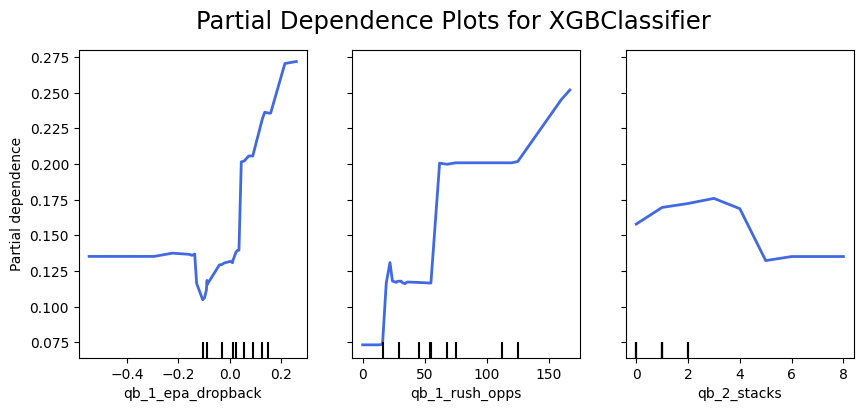

In [39]:
pdp_figure = plt.figure(figsize=(10, 4))
ax1 = pdp_figure.add_subplot(1, 1, 1)

pdp_dict = {
    'linewidth' : 2,
    'color' : 'royalblue',
           }

pdp_display = PartialDependenceDisplay.from_estimator(XGB, X=X_train, features=[5, 14, 4], line_kw=pdp_dict, ax=ax1)

plt.suptitle('Partial Dependence Plots for XGBClassifier', fontsize=17.5)


plt.show()

I chose our two most important features (QB1 EPA/Dropback and QB1 rushing opportunities) along with a feature commonly found useful (# of stacks for QB2) to focus on using Partial Dependence plots. As can be seen above, the model found that playoff probability increased significantly with increases in both EPA/Dropback and # of rushing attempts for teams' QB1. Additionally, stacking players with a team's second quarterback drafted has a positive impact on playoff probability up until 4 stacks, with any additional stacked players hurting playoff probability.

In [40]:
explainer = shap.Explainer(XGB, X_train)
shap_values = explainer(X_train)

100%|===================| 338294/338400 [17:53<00:00]        

In [42]:
# Playoff Team Waterfall
shap.plots.waterfall(shap_values[37])

Now using SHAP to evaluate my XGBoost model, we can observe how the model uses each feature to create a prediction for a playoff team. Specifically, we can see that this team's first quarterback having a high amount of rushing opportunities and a high EPA/Dropback increased the model's playoff probability prediction.

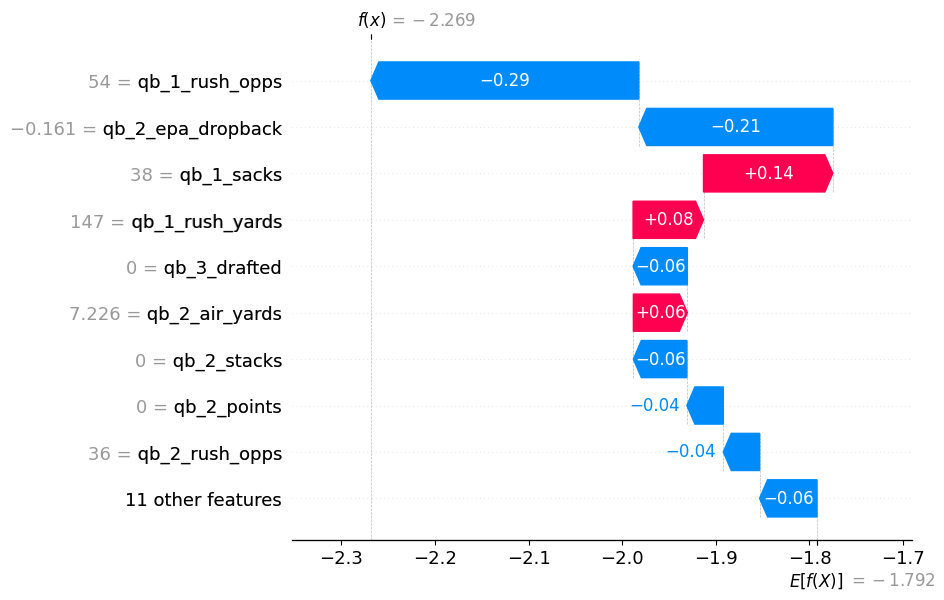

In [43]:
# Non-Playoff Team Waterfall
shap.plots.waterfall(shap_values[8])

On the other hand, for a non-playoff team, having a low number of QB1 rushing opportunities and an ineffective QB2 brought down the playoff probability prediction of the XGBoost model.

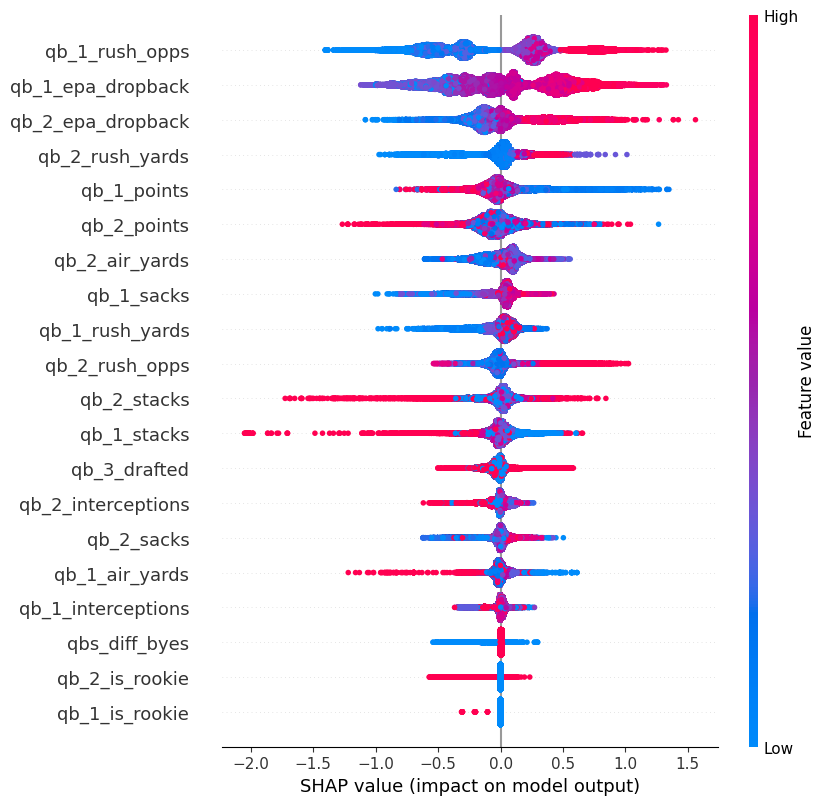

In [45]:
shap.plots.beeswarm(shap_values, max_display=20)

Using a beeswarm plot, the importance of rushing ability and a high EPA/Dropback for both quarterbacks is once again evident, reinforcing our earlier analysis. Stacks have varying levels of success, with a very high number of stacks often being associated with a lower playoff probability, though the success and relevance of the stacks likely plays a large role.

## Limitations and Further Research

Before concluding, I'd like to identify areas of limitation and further investigation.

With respect to the XGBoost playoff model, using quarterback-only data to determine a team's likelihood to make the playoff does not take into account the performance of the rest of the roster. Even perfect quarterback drafting does not guarantee making the playoffs, and that is a significant limitation on the model.

For further research, I am interested in how the results I have found in this project can be combined with playoff quarterback strategy.

## Conclusion

In this project, I presented information for how to tackle the strategy behind drafting quarterbacks in Best Ball Mania in order to maximize playoff probability. While there is no silver bullet to guarantee a playoff appearance, key findings indicate the success of certain strategies. Specifically, the prevalence of highly drafted, elite quarterbacks on playoff teams in BBMIII stands out. If one of these top quarterbacks cannot be secured, waiting through the "qb dead zone" and finding value in later windows of the draft appears to be a fruitful tactic. 

When teams do decide to draft quarterbacks, the evidence shows that drafting rushing ability and good quarterbacks by EPA/Dropback can be an effective strategy. There is certainly more research that can be done into stacks, but I found that they are useful as long as they are not overdone.

Looking onto BBMIV, my project advocates for the drafting of early fantasy studs like Jalen Hurts, Lamar Jackson, and Justin Fields, and looking for upside later on with rushing ability or possible stacks.